# Does raising the minimum wage negatively impact the demand for labor?

This notebook performs data cleaning, visualization, and exploratory statistical analysis to examine the question:
**Does raising the minimum wage negatively impact the demand for labor?**
We model demand for labor using national unemployment data.

We further break this question down into three sub-questions:

### 1. Do minimum wage increases correlate with unemployment increases?

### 2. If minimum wage cannot explain all unemployment changes, do the increases cause small, temporary effects?

### 3. Do minimum wage changes correlate with recessions, or with unusually steep unemployment increases?

# First we will clean the datasets

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

pd.set_option("display.expand_frame_repr", False)


In [10]:
#Clean and setup the minimum wage data
min_wage = pd.read_csv("Data/federalMinimumWage.csv")
min_wage.columns = min_wage.columns.str.strip()

# Convert Effective Date → datetime
min_wage["Effective Date"] = (
    min_wage["Effective Date"]
    .astype(str)
    .str.strip()
)
min_wage["Effective Date"] = pd.to_datetime(
    min_wage["Effective Date"],
    format= "%b %d %Y",
    errors="coerce"
)

# Remove $ signs and convert to float
wage_cols = ["interstateWage", "stateWage", "nonFarmWage", "farmWage"]

for col in wage_cols:
    min_wage[col] = (
        min_wage[col]
        .astype(str)
        .str.replace("$", "", regex=False)
        .str.replace(",", "", regex=False)
        .replace("0", np.nan)
        .astype(float)
    )

# Select the interstateWage as the federal wage, and readd it as a new column
min_wage["federalWage"] = min_wage["interstateWage"]

# Compute change in federal minimum wage
min_wage["wageChange"] = min_wage["federalWage"].diff()

# Optional: replace NaN for the first row with 0
min_wage["wageChange"] = min_wage["wageChange"].fillna(0)



In [9]:
#Clean and setup the unemployment rate data
unemp = pd.read_csv("Data/unemploymentRate.csv")
unemp.columns = unemp.columns.str.strip()

# Convert Effective Date → datetime
unemp["observation_date"] = (
    unemp["observation_date"]
    .astype(str)
    .str.strip()
)
unemp["observation_date"] = pd.to_datetime(
    unemp["observation_date"],
    format="%Y-%m-%d",
    errors="coerce"
)

# Convert unemployment rate to float
unemp["UNRATE"] = unemp["UNRATE"].astype(float)


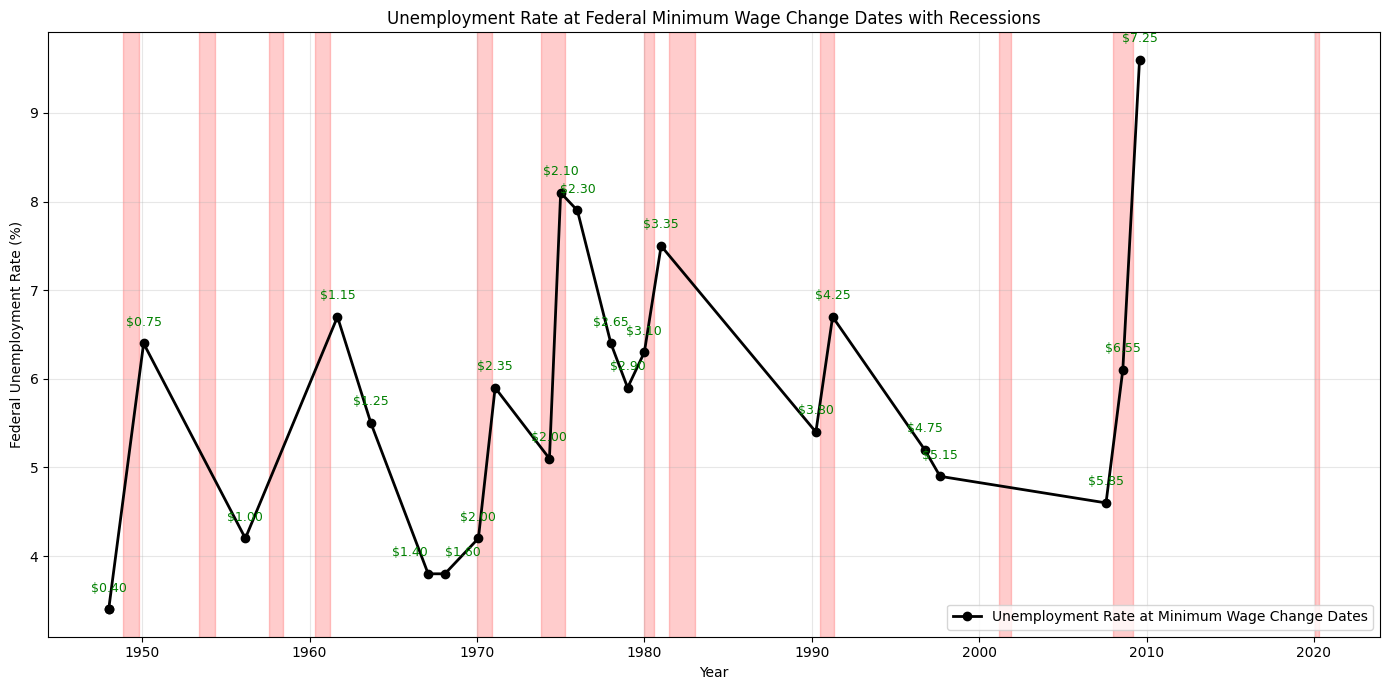

In [4]:
# Keep only real wage changes
mw_changes = min_wage[min_wage["wageChange"] != 0].copy()

# Merge each min wage change date with nearest unemployment observation
merged = pd.merge_asof(
    mw_changes.sort_values("Effective Date"),
    unemp.sort_values("observation_date"),
    left_on="Effective Date",
    right_on="observation_date",
    direction="nearest"
)

plt.figure(figsize=(14, 7))

# Plot unemployment only at those points
plt.plot(
    merged["observation_date"],
    merged["UNRATE"],
    marker="o",
    linewidth=2,
    label="Unemployment Rate at Minimum Wage Change Dates",
    color="black"
)

# Annotate each point with the new minimum wage
for idx, row in merged.iterrows():
    alignment = "center"
    if row["federalWage"] == 0.30:
        continue
    if row["federalWage"] == 1.40:
        alignment = "right"
    if row["federalWage"] == 1.60:
        alignment = "left"

    plt.text(
        row["observation_date"],
        row["UNRATE"] + 0.2,
        f"${row['federalWage']:.2f}",
        ha=alignment,
        fontsize=9,
        color="green"
    )

# Shade recession periods
recession_df = unemp.sort_values("observation_date")[["observation_date", "Recession"]]
recession_df["prev"] = recession_df["Recession"].shift(1).fillna(0)

starts = recession_df[(recession_df["Recession"] == 1) & (recession_df["prev"] == 0)]["observation_date"].tolist()
ends   = recession_df[(recession_df["Recession"] == 0) & (recession_df["prev"] == 1)]["observation_date"].tolist()

if len(ends) < len(starts):
    ends.append(recession_df["observation_date"].max())

for start, end in zip(starts, ends):
    plt.axvspan(start, end, color="red", alpha=0.2)

# Plot
plt.title("Unemployment Rate at Federal Minimum Wage Change Dates with Recessions")
plt.xlabel("Year")
plt.ylabel("Federal Unemployment Rate (%)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Unemployment Rate at Federal Minimum Wage Change Dates with Recessions


The above graph shows the unemployment rate at the time of the change in the minimum wage. Highlighted in red are the times that are historically classified as generally agreed upon recessions. The Average change in percent unemployment after each minimum wage change until the next change calculated in the following cell is 0.27. This is the amount of change that can be attributed on average to changes in minimum wage if you take the slope of the unemployment between wage requirement changes as the average.


There are some recessions that fall between the wage changes, and many recessions that are framed by wage changes showing that their effect is relatively negligible, but this look at the data excludes the majority of the fine behavior of the labor market, and reduces the unemployment figures to just one point when wage change is legally required.


If the only significant factor of labor demand was price for minimum wage, that is not born out in the data at this simplicity at the federal scale. In the code block following, the average change in percent unemployment after each minimum wage change until the next change is 0.27% or 27 unemployed for every 10,000 possible workers.


To review the question, do minimum wage increases correlate with unemployment increases? If it does at all, the effect is not significant on the wider job market and does not strongly correlate with recessions.



In [5]:

# Simple average change calculation
# Compute next unemployment value after each change
merged["next_UNRATE"] = merged["UNRATE"].shift(-1)

# Compute the change in unemployment following the wage change
merged["delta_UNRATE"] = merged["next_UNRATE"] - merged["UNRATE"]

# Drop the last row (no next point)
merged_clean = merged.dropna(subset=["delta_UNRATE"])

# Compute the average change
average_change = merged_clean["delta_UNRATE"].mean()

print("Average change in percent unemployment after each minimum wage change until the next change:")
print(average_change)

Average change in percent unemployment after each minimum wage change until the next change:
0.2695652173913043


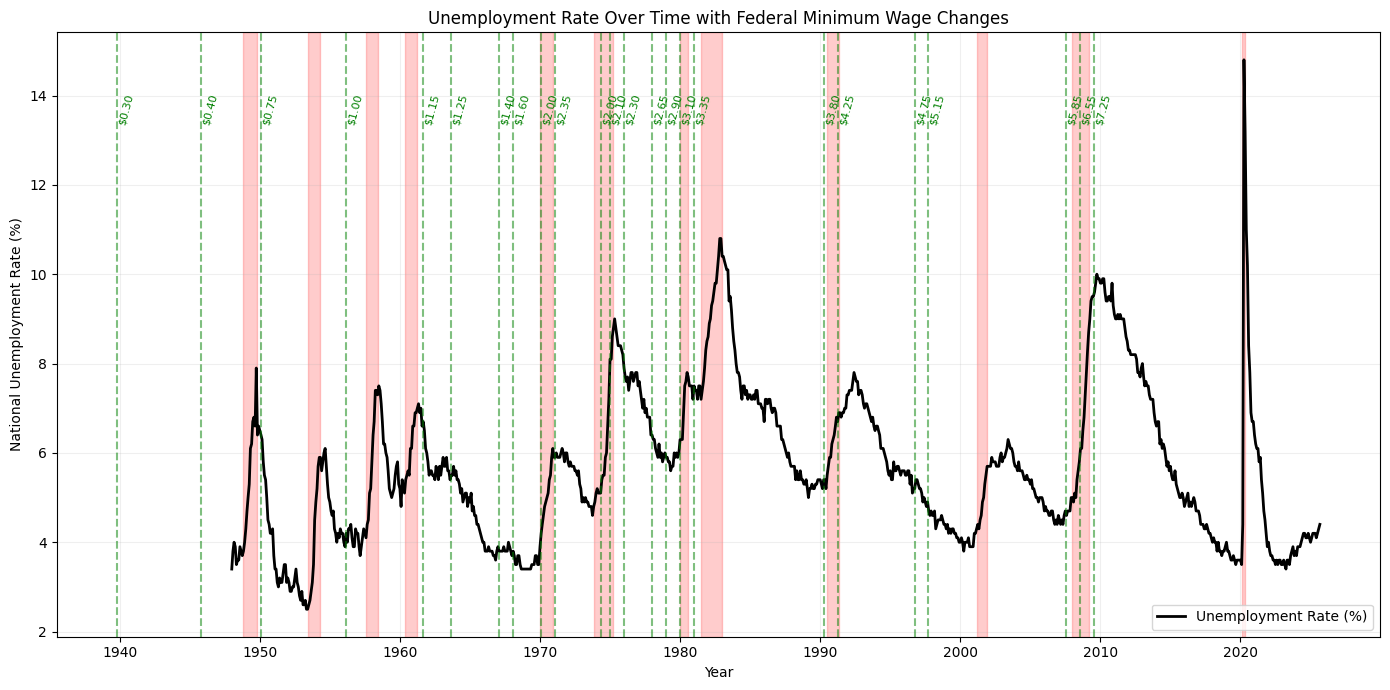

In [6]:
plt.figure(figsize=(14, 7))

# Change the data to only include rows where there was a change in minimum wage
mw_changes = min_wage[min_wage["wageChange"] != 0]

# Plot unemployment rate
plt.plot(
    unemp["observation_date"],
    unemp["UNRATE"],
    label="Unemployment Rate (%)",
    linewidth=2,
    color="black"
)

# Add vertical lines for minimum wage changes
for idx, row in mw_changes.iterrows():
    date = row["Effective Date"]
    wage = row["federalWage"]
    plt.axvline(date, color="green", linestyle="--", alpha=0.5)
    plt.text(
        date,
        unemp["UNRATE"].max() * 0.95,  # place text near top
        f"${wage:.2f}",
        rotation=75,
        verticalalignment="top",
        fontsize=8,
        color="green"
    )


recession_df = unemp.sort_values("observation_date")[["observation_date", "Recession"]]
recession_df["prev"] = recession_df["Recession"].shift(1).fillna(0)

starts = recession_df[(recession_df["Recession"] == 1) & (recession_df["prev"] == 0)]["observation_date"].tolist()
ends   = recession_df[(recession_df["Recession"] == 0) & (recession_df["prev"] == 1)]["observation_date"].tolist()

if len(ends) < len(starts):
    ends.append(recession_df["observation_date"].max())

for start, end in zip(starts, ends):
    plt.axvspan(start, end, color="red", alpha=0.2)


plt.title("Unemployment Rate Over Time with Federal Minimum Wage Changes")
plt.xlabel("Year")
plt.ylabel("National Unemployment Rate (%)")
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()

plt.show()

## Unemployment Rate Over Time with Federal Minimum Wage Changes


Knowing that minimum wage changes have seemingly inconclusive impact on the entire behavior of unemployment, it can be more useful to look at the local effects. The above graph has the full set of data on unemployment, with recessions in red, and minimum wage changes in greed on dotted lines. The Fair Labor Standards Act from 1938 - 2009 has not been amended since 2009. The Bureau of Labor Statistics only started collecting robust monthly unemployment data from 1948 and has, until very recently, been doing so into the present.


This version of the graph gives a better understanding of recessions and the behavior of unemployment during them. Significant steep unemployment spikes happen during recessions. Interestingly, Minimum Wage Changes seem to happen both before and after a recession. This pattern indicates that though there may be some job loss, it is not a recession trigger. If it were a direct trigger, we would see them only directly before recessions and not within or after. Out of the 12 recessions marked, 6 of them have minimum wage increases within 6 months of the end of the recession. Out of the 24 minimum wage increases marked, there are 11 that do not coincide with a recession at all. Of the remaining 7 minimum wage increases, 2 have no unemployment data to connect with, and the other 5 show a momentary decline or flattening of unemployment within or preceding their closest recession.


In the following codeblock, average behavior is calculated. Looking at the average behavior one year after the change instead of looking from change to change helps us draw this conclusion.The average change in percent unemployment in the approximate year following each minimum wage change is 0.18%, or 18 unemployed in every 10,000 workers. This is less than the change to change average from the previous graph. If you look at the 3 month window, the effect almost disappears where the average change is reported to be 0.007% or 7 unemployed in 100,000 workers. There are not enough significant figures to support such a small finding so this is functionally zero unemployment change given minimum wage increase within a 3 month range.


Given that all else is not equal and minimum wage can not account for the all change in unemployment, do minimum wage increases have a small temporary effect? If they do, it is not evident in the national data. It seems that there may be some very slight increase in unemployment due to wage floors, but not nearly as significant as the laws of supply and demand might suggest.


In [11]:

# Create "next wage change date" via shift
min_wage["next_change"] = min_wage["Effective Date"].shift(-1)

# Compute "one year later" for each change
min_wage["one_year_later"] = min_wage["Effective Date"] + pd.DateOffset(years=1)

# Compute "three months later" for each change
min_wage["three_months_later"] = min_wage["Effective Date"] + pd.DateOffset(months=3)

# Target date = min(next_change, one_year_later), handling NaN properly
min_wage["one_year_target_date"] = min_wage[["one_year_later", "next_change"]].min(axis=1)

# Target date = min(next_change, three_months_later), handling NaN properly
min_wage["three_month_target_date"] = min_wage[["three_months_later", "next_change"]].min(axis=1)

# Merge unemployment ON OR AFTER wage-change date (BACKWARD=False selects nearest future)
unemp_after_change = pd.merge_asof(
    min_wage[["Effective Date"]],
    unemp,
    left_on="Effective Date",
    right_on="observation_date",
    direction="forward"
).rename(columns={"UNRATE": "current_unemp"})

# Merge unemployment ON OR AFTER target date
unemp_after_one_year_target = pd.merge_asof(
    min_wage[["one_year_target_date"]],
    unemp,
    left_on="one_year_target_date",
    right_on="observation_date",
    direction="forward"
).rename(columns={"UNRATE": "one_year_future_unemp"})

unemp_after_three_month_target = pd.merge_asof(
    min_wage[["three_month_target_date"]],
    unemp,
    left_on="three_month_target_date",
    right_on="observation_date",
    direction="forward"
).rename(columns={"UNRATE": "three_month_future_unemp"})

# Combine everything into a single dataframe
change_df = pd.concat(
    [
        min_wage[["Effective Date", "next_change", "one_year_later", "one_year_target_date", "three_months_later", "three_month_target_date"]],
        unemp_after_change["current_unemp"],
        unemp_after_one_year_target["one_year_future_unemp"],
        unemp_after_three_month_target["three_month_future_unemp"]
    ],
    axis=1
)

# Compute unemployment change
change_df["one_year_delta_unemp"] = change_df["one_year_future_unemp"] - change_df["current_unemp"]
change_df["three_month_delta_unemp"] = change_df["three_month_future_unemp"] - change_df["current_unemp"]

# Show results

print(change_df.head(5))
print(change_df.tail(5))
print("\nAverage change in percent unemployment in the approximate year following each minimum wage change:")
print(change_df["one_year_delta_unemp"].mean())
print("\nAverage change in percent unemployment in the approximate 3 months following each minimum wage change:")
print(change_df["three_month_delta_unemp"].mean())

  Effective Date next_change one_year_later one_year_target_date three_months_later three_month_target_date  current_unemp  one_year_future_unemp  three_month_future_unemp  one_year_delta_unemp  three_month_delta_unemp
0     1938-10-24  1939-10-24     1939-10-24           1939-10-24         1939-01-24              1939-01-24            3.4                    3.4                       3.4                   0.0                      0.0
1     1939-10-24  1945-10-24     1940-10-24           1940-10-24         1940-01-24              1940-01-24            3.4                    3.4                       3.4                   0.0                      0.0
2     1945-10-24  1950-01-25     1946-10-24           1946-10-24         1946-01-24              1946-01-24            3.4                    3.4                       3.4                   0.0                      0.0
3     1950-01-25  1956-03-01     1951-01-25           1951-01-25         1950-04-25              1950-04-25            6.4  

For an additional check, the final codeblock attempts a very simple logistic regression where minimum wage is checked for correlation with recessions. Logistic regression uses log odds 

In [ ]:
# Full Dataset Logistic Regression for general correlation between minimum wage and recession
# Ensure sorted
min_wage_sorted = min_wage.sort_values("Effective Date")[["Effective Date", "federalWage"]]
unemp_sorted = unemp.sort_values("observation_date")

# Merge minimum wage into unemployment with backfill/forward-fill
merged_lr = pd.merge_asof(
    unemp_sorted,
    min_wage_sorted,
    left_on="observation_date",
    right_on="Effective Date",
    direction="backward"  # give each month the last known wage
)

# Drop the Effective Date column after merge
merged_lr = merged_lr.drop(columns=["Effective Date"])

# Forward-fill any remaining NaN values in federalWage
merged_lr["federalWage"] = merged_lr["federalWage"].ffill()

# Prepare features
X = merged_lr[["federalWage"]]
y = merged_lr["Recession"]

# Standardize wage (optional, but helps interpretation)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit model
model = LogisticRegression()
model.fit(X_scaled, y)

print("Coefficient:", model.coef_[0][0])
print("Intercept:", model.intercept_[0])



Coefficient: -0.537598021421229
Intercept: -1.8938083058393025


In [18]:
# Setup for full logistic regression with train/test split
# Split data into features and target
min_wage_sorted = min_wage.sort_values("Effective Date")[["Effective Date", "federalWage"]]
unemp_sorted = unemp.sort_values("observation_date")

merged_lr = pd.merge_asof(
    unemp_sorted,
    min_wage_sorted,
    left_on="observation_date",
    right_on="Effective Date",
    direction="backward"
).drop(columns=["Effective Date"])

merged_lr["federalWage"] = merged_lr["federalWage"].ffill()

X = merged_lr[["federalWage"]]
y = merged_lr["Recession"]

# Define train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Create regular pipeline with scaler and logistic regression
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000))
])

# Create balanced pipeline with scaler and logistic regression
balanced_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000,class_weight="balanced"))
])

pipeline.fit(X_train, y_train)
balanced_pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Balanced Predictions
b_y_pred = balanced_pipeline.predict(X_test)
b_y_prob = balanced_pipeline.predict_proba(X_test)[:, 1]

# Balanced Metrics
b_accuracy = accuracy_score(y_test, b_y_pred)
b_precision = precision_score(y_test, b_y_pred)
b_recall = recall_score(y_test, b_y_pred)
b_f1 = f1_score(y_test, b_y_pred)
b_cm = confusion_matrix(y_test, b_y_pred)

# McFadden Pseudo-R² to check model fit
def mcfadden_r2(model, X, y):
    """
    McFadden pseudo-R² = 1 - (ln(L_model) / ln(L_null))
    """
    # log-likelihood of fitted model
    p = model.predict_proba(X)[:, 1]
    eps = 1e-9  # avoid log(0)
    ll_model = np.sum(y*np.log(p+eps) + (1-y)*np.log(1-p+eps))

    # log-likelihood of null model (only intercept)
    p_null = np.mean(y)
    ll_null = np.sum(y*np.log(p_null+eps) + (1-y)*np.log(1-p_null+eps))

    return 1 - (ll_model / ll_null)

pseudo_r2 = mcfadden_r2(pipeline, X_test, y_test)
b_pseudo_r2 = mcfadden_r2(balanced_pipeline, X_test, y_test)

# Display Results
print("\n----- NORMAL MODEL PERFORMANCE -----")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nConfusion Matrix:")
print(cm)
print(f"\nMcFadden pseudo-R²: {pseudo_r2:.4f}")

# Display Results
print("\n----- BALLANCED MODEL PERFORMANCE -----")
print(f"Accuracy:  {b_accuracy:.4f}")
print(f"Precision: {b_precision:.4f}")
print(f"Recall:    {b_recall:.4f}")
print(f"F1 Score:  {b_f1:.4f}")
print("\nConfusion Matrix:")
print(b_cm)
print(f"\nMcFadden pseudo-R²: {b_pseudo_r2:.4f}")

# Extract and display model coefficients
logreg = pipeline.named_steps["logreg"]
coef = logreg.coef_[0][0]
intercept = logreg.intercept_[0]

# Extract and display model coefficients
b_logreg = balanced_pipeline.named_steps["logreg"]
b_coef = b_logreg.coef_[0][0]
b_intercept = b_logreg.intercept_[0]

print("\n----- NORMAL MODEL COEFFICIENTS -----")
print(f"Coefficient (scaled wage): {coef:.4f}")
print(f"Intercept: {intercept:.4f}")

print("\n----- BALANCED MODEL COEFFICIENTS -----")
print(f"Coefficient (scaled wage): {coef:.4f}")
print(f"Intercept: {intercept:.4f}")



----- NORMAL MODEL PERFORMANCE -----
Accuracy:  0.8590
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000

Confusion Matrix:
[[201   0]
 [ 33   0]]

McFadden pseudo-R²: 0.0528

----- BALLANCED MODEL PERFORMANCE -----
Accuracy:  0.6368
Precision: 0.2234
Recall:    0.6364
F1 Score:  0.3307

Confusion Matrix:
[[128  73]
 [ 12  21]]

McFadden pseudo-R²: -0.5856

----- NORMAL MODEL COEFFICIENTS -----
Coefficient (scaled wage): -0.4963
Intercept: -1.8746

----- BALANCED MODEL COEFFICIENTS -----
Coefficient (scaled wage): -0.4963
Intercept: -1.8746


c:\Users\crawfordd1\git\minimumWageSupplyVsDemand\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### Discussion of logistic regression


Retrospectively, this methodology was inherently flawed. If you look at the confusion matrix, you will notice immediately that the unbalanced model always predicts no recession. In the dataset, recessions are rare, at about a 85% 15% split. When the load is balanced, significant inaccuracy arises because of overfitting to the recession segment of the data. Without the load balancing, the model attains its highest accuracy in always predicting no recession because that is the most likely.


This outcome makes sense. Although the two things seem random, policy decisions are typically carefully organized to have the most positive impact for the most people and to avoid negative impact where possible and popular. Once all the decision makers have had their say, the timeliness is mostly gone, but change is still needed. Recessions are also complex and hold even greater complexities like GDP growth, Consumer sentiment, CPI inflation rates, Industrial production, (Bond) Yield curve (10Y–3M spread), Stock market trends, and Housing development, however minimum wage policy and its impacts on unemployment are the focus.


When we look at the unaffected McFadden scores it also confirms our previous understanding. The unaffected distribution score is close to 0.05. When your pseudo R² score is close to or less than 0, your model is as good as guessing class 0 the entire time, which is exactly what we did.


What correlation, if any, do minimum wage increases have with recessions or increased unemployment? This does not really answer the question beyond aligning with previous indicators from the averages taken above. A better method must be pursued.





---- Δ Unemployment at 3 Months vs Δ Minimum Wage ----
Coefficient: 0.1460234680573664
Intercept: -0.009256844850065213
R²: 0.007502123129552785



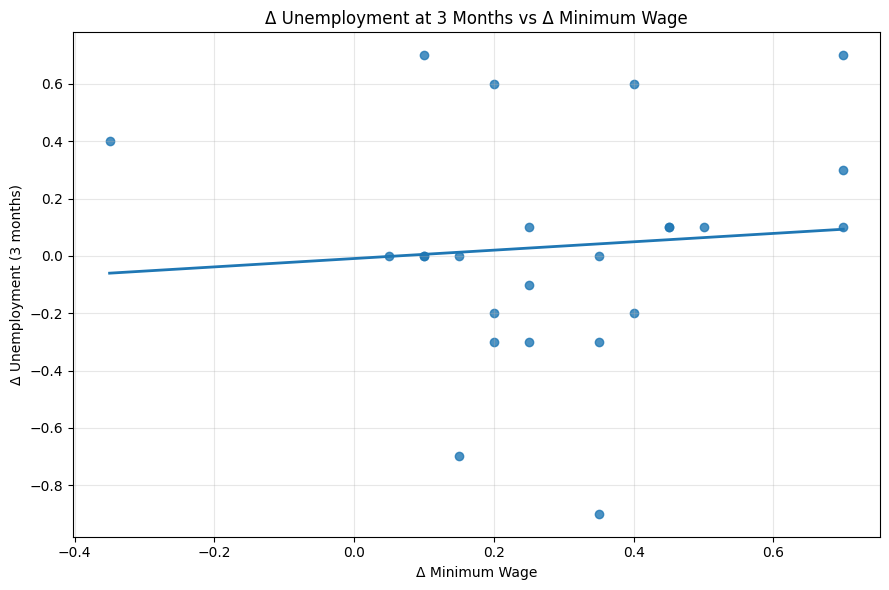

---- Δ Unemployment at 6 Months vs Δ Minimum Wage ----
Coefficient: 0.17405475880052218
Intercept: 0.086734028683181
R²: 0.002467288927808564



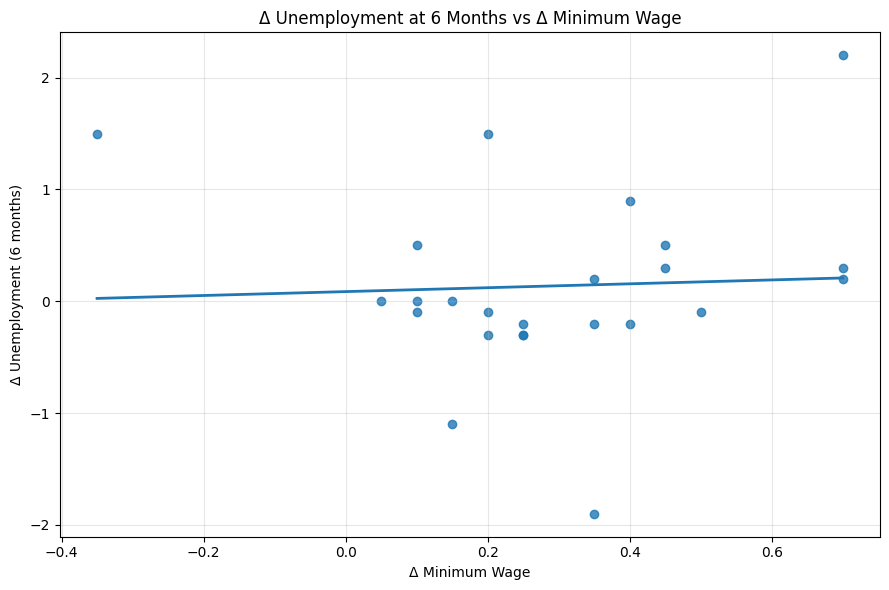

---- Δ Unemployment at 24 Months vs Δ Minimum Wage ----
Coefficient: 1.524771838331157
Intercept: 0.10110821382007912
R²: 0.03603357729798351



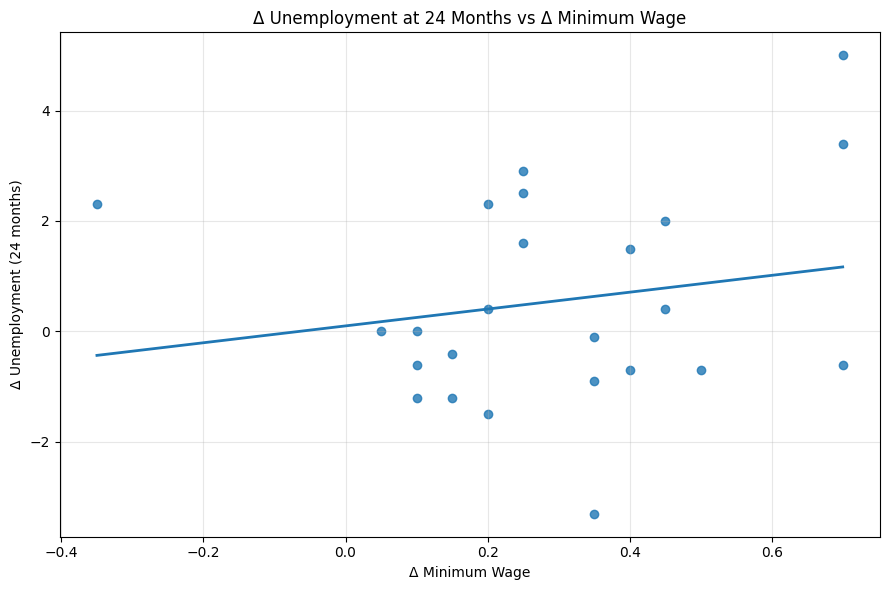

In [ ]:
# Minimum Wage vs Unemployment Change Scatter Plots with Regression Lines
mw = min_wage[min_wage["wageChange"] != 0].copy()
mw = mw.sort_values("Effective Date")

# Define time offsets
offsets = {
    "3m": pd.DateOffset(months=3),
    "6m": pd.DateOffset(months=6),
    "24m": pd.DateOffset(months=24)
}

# Function to compute unemployment delta for an offset
def compute_unemployment_delta(offset_label, offset):
    temp = mw.copy()
    temp[f"target_{offset_label}"] = temp["Effective Date"] + offset

    # unemployment at change
    start = pd.merge_asof(
        temp[["Effective Date", "wageChange"]].sort_values("Effective Date"),
        unemp.sort_values("observation_date"),
        left_on="Effective Date",
        right_on="observation_date",
        direction="nearest"
    ).rename(columns={"UNRATE": f"unemp_start_{offset_label}"})

    # unemployment at target
    end = pd.merge_asof(
        temp[[f"target_{offset_label}"]].sort_values(f"target_{offset_label}"),
        unemp.sort_values("observation_date"),
        left_on=f"target_{offset_label}",
        right_on="observation_date",
        direction="nearest"
    ).rename(columns={"UNRATE": f"unemp_end_{offset_label}"})

    # combine
    out = pd.concat([start, end[f"unemp_end_{offset_label}"]], axis=1)
    out[f"delta_unemp_{offset_label}"] = (
        out[f"unemp_end_{offset_label}"] - out[f"unemp_start_{offset_label}"]
    )
    return out[["Effective Date", "wageChange", f"delta_unemp_{offset_label}"]]


# Build all Δ unemployment tables
df_3m = compute_unemployment_delta("3m", offsets["3m"])
df_6m = compute_unemployment_delta("6m", offsets["6m"])
df_24m = compute_unemployment_delta("24m", offsets["24m"])

# Merge them into one
all_changes = (
    df_3m
    .merge(df_6m, on=["Effective Date", "wageChange"])
    .merge(df_24m, on=["Effective Date", "wageChange"])
)

# Function to plot scatter + regression line
def plot_regression(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(9, 6))
    
    # Scatter
    plt.scatter(x, y, alpha=0.8)

    # Regression
    model = LinearRegression()
    model.fit(x.values.reshape(-1, 1), y)

    x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    y_pred = model.predict(x_range)

    plt.plot(x_range, y_pred, linewidth=2)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Print regression stats
    print("----", title, "----")
    print("Coefficient:", model.coef_[0])
    print("Intercept:", model.intercept_)
    print("R²:", model.score(x.values.reshape(-1, 1), y))
    print()

    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# --------------------------------------------
# 5. Plot for each time horizon
# --------------------------------------------
plot_regression(
    all_changes["wageChange"],
    all_changes["delta_unemp_3m"],
    xlabel="Δ Minimum Wage",
    ylabel="Δ Unemployment (3 months)",
    title="Δ Unemployment at 3 Months vs Δ Minimum Wage"
)

plot_regression(
    all_changes["wageChange"],
    all_changes["delta_unemp_6m"],
    xlabel="Δ Minimum Wage",
    ylabel="Δ Unemployment (6 months)",
    title="Δ Unemployment at 6 Months vs Δ Minimum Wage"
)

plot_regression(
    all_changes["wageChange"],
    all_changes["delta_unemp_24m"],
    xlabel="Δ Minimum Wage",
    ylabel="Δ Unemployment (24 months)",
    title="Δ Unemployment at 24 Months vs Δ Minimum Wage"
)


## Discussion of Linear Regression on ΔWage vs. ΔUnemployment

We then compared the change in minimum wage to the change in unemployment over 3-month, 6-month, and 24-month windows.

The regression lines show:

Very small slopes

R² values close to zero

Scattered, noise-like distributions

The 24-month regression is the only one with a weak structure, but even that is extremely small.

Thus:

What correlation, if any, do minimum wage increases have with recessions or increased unemployment?
Almost none.

Feature engineering might improve performance marginally, but the underlying signal is very weak.

## Conclusion

This analysis investigates whether federal minimum wage increases lead to higher unemployment or correlate with recessions. After exploring unemployment at wage change dates, basic unemployment time series, logistic regression, and linear regression on wage and unemployment changes, the conclusion is consistent across methods:

Federal minimum wage increases do not show any statistically meaningful relationship with unemployment spikes or recessions. Any detected effects are extremely small and likely overshadowed by broader macroeconomic forces.